# Imports

In [3]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import *
from models import *
from fit_GLM_decoder import *
# pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:6379',
 'object_store_address': '/tmp/ray/session_2021-12-06_13-38-41_639756_549758/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-12-06_13-38-41_639756_549758/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-12-06_13-38-41_639756_549758',
 'metrics_export_port': 57193,
 'node_id': 'c7bbe66e059d4e5355380f671b8fe481be11c7612d5696b856c866cf'}

# NonLin Decoder

In [120]:
args = arg_parser(jupyter=True)
MovModel = 2
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
# args['date_ani'] = '110421/J569LT'# args['date_ani']
# yaml_path = sorted(list((Path(args['save_dir']).expanduser() / date_ani / stim_type / 'GLM_Network_NL/').rglob('*.yaml')))
# args['shiftn']=7
args['train_shifter']=False
args['do_norm']=True
params_m1,file_dict,_ = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params_m1)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params_m1)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

params, ytr, ytrm, yte, ytem, xtr, xte, shift_in_tr, shift_in_te, output_size, input_size, model_type, meanbias, model_move = load_GLM_data(data, params_m1, train_idx, test_idx)
print('Model: {}, move_features: {}'.format(MovModel, params_m1['move_features']))


Done Loading Unaligned data
Model: 2, move_features: 4


In [18]:

class NLDecoder(nn.Module):
    def __init__(self, 
                    in_features, 
                    hidden_features,
                    out_features, 
                    shift_in=3, 
                    shift_hidden=20,
                    shift_out=3,
                    hidden_move=15,
                    reg_alph=None, 
                    reg_alph2=None,
                    reg_alphm=None, 
                    move_features=None, 
                    LinMix=False,
                    train_shifter=False,
                    meanbias = None,
                    device='cuda'):
        super(NLDecoder, self).__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.move_features = move_features
        self.LinMix = LinMix
        self.meanbias = meanbias
        
        self.Cell_NN = nn.Sequential(nn.Linear(self.in_features, self.hidden_features,bias=True),nn.Softplus(),nn.Linear(self.hidden_features, out_features,bias=True))
        self.activations = nn.ModuleDict({'SoftPlus':nn.Softplus(),
                                          'ReLU': nn.ReLU(),})
        torch.nn.init.uniform_(self.Cell_NN[0].weight, a=-1e-6, b=1e-6)
        
        # Initialize Regularization parameters
        self.reg_alph = reg_alph
        self.reg_alph2 = reg_alph2
        if self.reg_alph != None:
            self.alpha = reg_alph*torch.ones(1).to(device)
        if self.reg_alph2 != None:
            self.alpha2 = reg_alph2*torch.ones(1).to(device)
        
        # Initialize Movement parameters
        self.reg_alphm = reg_alphm
        if self.move_features != None:
            if reg_alphm != None:
                self.alpha_m = reg_alphm*torch.ones(1).to(device)
            self.posNN = nn.ModuleDict({'Layer0': nn.Linear(move_features, N_cells)})
            torch.nn.init.uniform_(self.posNN['Layer0'].weight,a=-1e-6,b=1e-6)
            torch.nn.init.zeros_(self.posNN['Layer0'].bias)

        # option to train shifter network
        self.train_shifter = train_shifter
        self.shift_in = shift_in
        self.shift_hidden = shift_hidden
        self.shift_out = shift_out
        if train_shifter:
            self.shifter_nn = nn.Sequential(
                nn.Linear(self.shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out)
            )
        
    
    def forward(self, inputs, move_input=None, eye_input=None, celln=None):

        ret = self.Cell_NN(inputs)
        # # Add Vs. Multiplicative
        # if move_input != None:
        #     if self.LinMix==True:
        #         output = output + self.posNN['Layer0'](move_input)
        #     else:
        #         move_out = self.posNN['Layer0'](move_input)
        #         # move_out = self.activations['SoftPlus'](move_out)
        #         move_out = torch.exp(move_out)
        #         output = output*move_out
        # ret = self.activations['ReLU'](output)
        return ret
    
    def loss(self,Yhat, Y): 
        if self.LinMix:
            loss_vec = torch.mean((Yhat-Y)**2,axis=0)
        else:
            loss_vec = torch.mean((Yhat-Y)**2,axis=0)
            # loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0)  # Log-likelihood
        if self.move_features != None:
            if self.reg_alph != None:
                l1_reg0 = self.alpha0*(torch.linalg.norm(self.Cell_NN['Layer0'].weight,axis=1,ord=1))
                l1_reg1 = self.alpha1*(torch.linalg.norm(self.Cell_NN['Layer1'].weight,axis=1,ord=1))
            else: 
                l1_reg0 = 0
                l1_reg1 = 0
            if self.reg_alphm != None:
                l1_regm = self.alpha_m*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=1))
            else: 
                l1_regm = 0
            loss_vec = loss_vec + l1_reg0 + l1_reg1 + l1_regm
        else:
            if self.reg_alph != None:
                l1_reg0 = torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in self.Cell_NN.named_parameters() if '0.weight' in name])
                l1_reg2 = torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in self.Cell_NN.named_parameters() if '2.weight' in name])
                loss_vec = loss_vec + self.alpha*(l1_reg0) + self.alpha2*(l1_reg2)
        
        return loss_vec


In [32]:
hidden_size = 128
output_size = ytr.shape[-1]
params['lambdas'] = [0]
params['Nepochs'] = 5000
track_all = True
l = 0
l1 = NLDecoder(input_size,hidden_size,output_size).to(device)
optimizer = optim.Adam(params=[{'params': [l1.Cell_NN[0].weight],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]}, #[p for name,p in l1.Cell_NN.named_parameters() if 'weight' in name]
                                {'params': [l1.Cell_NN[2].weight],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]},
                                {'params': [l1.Cell_NN[0].bias],'lr':params['lr_b'][1]},
                                {'params': [l1.Cell_NN[2].bias],'lr':params['lr_b'][1]},
                                # {'params': [param for name,param in l1.posNN.named_parameters() if 'weight' in name],'lr':params['lr_w'][1],'weight_decay':0},
                                # {'params': [param for name,param in l1.posNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},
                                ])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9999)

In [122]:
a=0; l=0; 
track_all = True
hidden_size = 128
output_size = ytr.shape[-1]
params['Nepochs'] = 2000

GLM_CV = {}
GLM_CV['loss_regcv']      = np.zeros((params['nalph'], params['nlam'], output_size))
GLM_CV['pred_cv']         = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
GLM_CV['out_cv']          = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
GLM_CV['tloss_trace_all'] = np.zeros((params['nalph'], params['nlam'], output_size, params['Nepochs']), dtype=np.float32)
GLM_CV['vloss_trace_all'] = np.zeros((params['nalph'], params['nlam'], output_size, params['Nepochs']), dtype=np.float32)
GLM_CV['r2_test']         = np.zeros((params['nalph'], params['nlam'], output_size))

pbar = tqdm(range(len(params['lambdas'])))
for reg_lam, l in enumerate(pbar):
    l1 = NLDecoder(input_size,hidden_size,output_size).to(device)
    optimizer = optim.Adam(params=[{'params': [l1.Cell_NN[0].weight],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]}, #[p for name,p in l1.Cell_NN.named_parameters() if 'weight' in name]
                                    {'params': [l1.Cell_NN[2].weight],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]},
                                    {'params': [l1.Cell_NN[0].bias],'lr':params['lr_b'][1]},
                                    {'params': [l1.Cell_NN[2].bias],'lr':params['lr_b'][1]},
                                    ])

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(params['Nepochs']/2))
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9999)

    if (a==0) & (l==0):
        for name, p in l1.named_parameters():
            GLM_CV[name] = np.zeros((params['nalph'],params['nlam'],) + p.shape, dtype=np.float32)
    elif (l!=0) & (params['MovModel']==1):
        l1.load_state_dict(state_dict)

    vloss_trace, tloss_trace, l1, optimizer, scheduler, Epoch_GLM = train_model(xtr,xte,xtrm,xtem,shift_in_tr,shift_in_te,ytr,yte,params['Nepochs'],l1,optimizer,scheduler,pbar=pbar)
    model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{}.pth'.format(model_type, params['WC_type'], int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'], a, l, Kfold)

    for name, p in l1.named_parameters():
        GLM_CV[name][a,l] = p.clone().cpu().detach().numpy()

    if (l == 0) & (params['MovModel']==1):
        state_dict = l1.state_dict()

    GLM_CV['tloss_trace_all'][a, l] = tloss_trace.T
    GLM_CV['vloss_trace_all'][a, l] = vloss_trace.T
    
    pred = l1(xte, xtem, shift_in_te)
    GLM_CV['loss_regcv'][a, l] = l1.loss(pred, yte).cpu().detach().numpy()
    GLM_CV['pred_cv'][a, l] = pred.detach().cpu().numpy().squeeze().T
    out = l1(xtr, xtrm, shift_in_tr)
    GLM_CV['out_cv'][a, l] = out.detach().cpu().numpy().squeeze().T

    # sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=data['test_nsp'])[params['bin_length']:-params['bin_length']]
    # pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_CV['pred_cv'][a, l])[:,params['bin_length']:-params['bin_length']].T
    # GLM_CV['r2_test'][a,l] = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
    
    # if params['train_shifter']:
    #     torch.save({'reg_alph': reg_alph, 'reg_lam':reg_lam, 'model_state_dict': l1.state_dict(),'optimizer_state_dict': optimizer.state_dict(),}, (params['save_model_shift'] / model_name))
        
if (params['MovModel'] ==1):
    GLM_CV['loss_regcv'][:, 0, :] = np.nan

malph, mlam, cellnum = np.where(GLM_CV['loss_regcv'] == np.nanmin(GLM_CV['loss_regcv'], axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

GLM_Data = {}
for key in GLM_CV.keys():
    if 'shifter' in key:
        GLM_Data[key] = GLM_CV[key][malph,mlam]
    else:
        GLM_Data[key] = GLM_CV[key][malph,mlam,cellnum]

  0%|          | 0/41 [00:00<?, ?it/s]

IndexError: index 128 is out of bounds for axis 2 with size 128

In [117]:
pred_test = GLM_Data['pred_cv'].squeeze()
move_test = yte.cpu().detach().numpy().T

In [118]:
r2_test = np.array([(np.corrcoef(move_test[moven],pred_test[moven])[0, 1])**2 for moven in range(move_test.shape[0])])
r2_test

array([0.21196451, 0.1987252 , 0.09055121, 0.29368463])

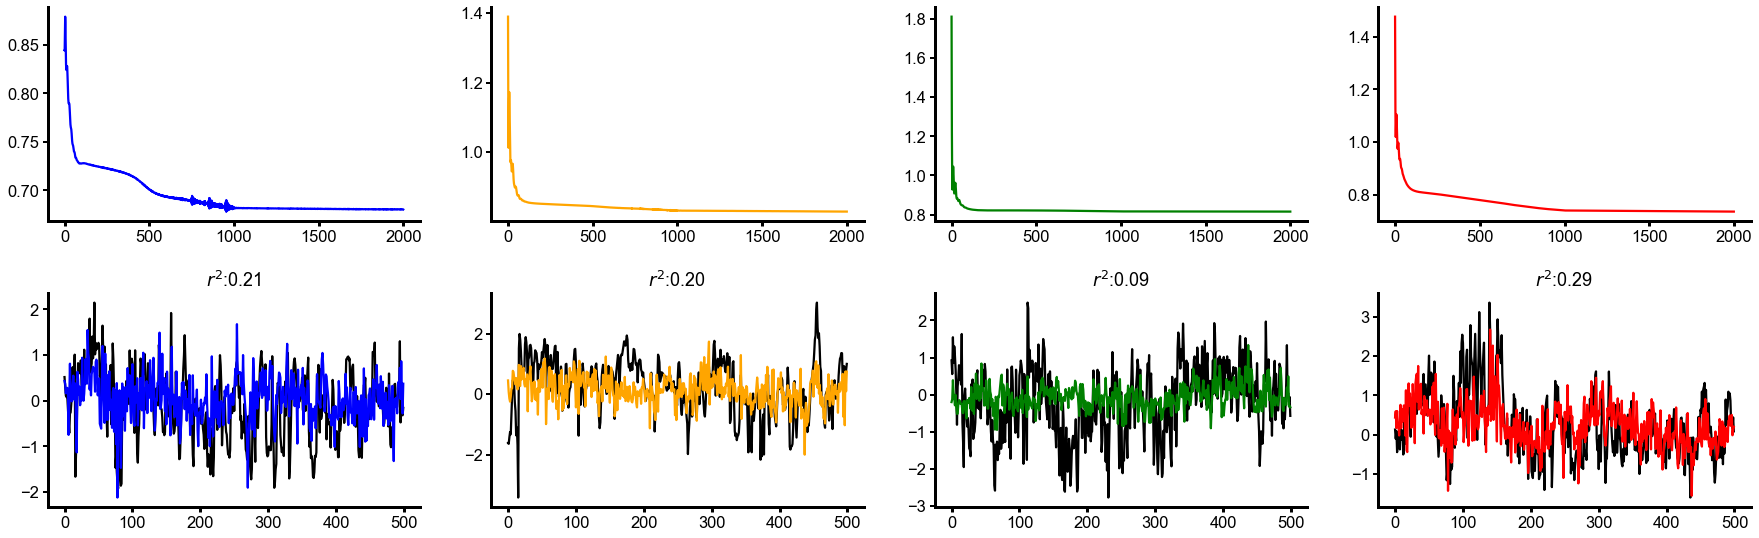

In [119]:
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
clrs = ['blue','orange','green','red','magenta']
nrows = len(titles)
t = 2000
dt = 500

fig, axs = plt.subplots(2,nrows,figsize=(25,8))
# axs = axs.flatten()
for moven in range(nrows):
    ax = axs[0,moven]
    ax.plot(GLM_Data['vloss_trace_all'][moven],c=clrs[moven])
    
    ax = axs[1,moven]
    ax.plot(move_test[moven,t:t+dt],c='k')
    ax.plot(pred_test[moven,t:t+dt],c=clrs[moven])
    ax.set_title('$r^2$:{:.02f}'.format(r2_test[moven]))

plt.tight_layout()

In [ ]:
GLM_Data['vloss_trace_all']